# autograd

> Fill in a module description here

In [ ]:
#| default_exp autograd

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import (
    List,
    Optional,
    Tuple,
    Union,
    Set,
)

import numpy
import numpy as ARRAY_API
import minima as mi
from graphviz import Digraph

Today, I'd like to introduce you to the automatic differentiation component of my deep learning framework, Minima. I am going to explain a specific module, called Micrograd, in detail. I had released the Micrograd module on Github a couple of years ago, but never provided an in-depth explanation of its functioning. So here we go.

Micrograd, at its core, is an autograd (short for automatic gradient) engine. It implements the backpropagation algorithm, a crucial aspect of deep learning. Backpropagation enables efficient computation of the gradient (rate of change) of a loss function (something we aim to minimize) with respect to the weights of a neural network. This enables us to fine-tune the weights of the neural network iteratively, reducing the loss function, and in turn, increasing the accuracy of the network. Backpropagation is central to most modern deep neural network libraries, such as PyTorch or Jax.

To help illustrate what Micrograd does, consider a simple example. We start with two inputs, a and b, encapsulated in special objects we call "Value" objects. We then construct a mathematical expression involving a and b. The Value objects help Micrograd to keep track of how these inputs are being transformed, and the operations performed on them, resulting in a complete mathematical "expression graph".

Micrograd then performs two key tasks. First, it carries out a 'forward pass' - it evaluates the final value of the expression we've created. But more importantly, it then performs a 'backward pass' - essentially a run of the backpropagation algorithm. It starts from the final value and traces back through the expression graph, calculating the derivative (rate of change) of the final value with respect to each of the original inputs and intermediate nodes, using the chain rule of calculus.

This is crucial as these derivatives tell us how much our final value is affected by small changes in the inputs. In essence, the derivative of the final value with respect to an input is a measure of the "sensitivity" of the final value to that input.

Now, the example above might seem abstract - the expression we constructed didn't have any particular meaning, it was just a demonstration of the capabilities of Micrograd. But the reason it's useful is that this kind of mathematical expression is exactly what neural networks are - they take input data and network weights as inputs, and transform them through a series of mathematical operations into a final output, usually a prediction or a loss value.

One thing to note here is that Micrograd operates at the level of individual scalar values, not n-dimensional tensors as you'd typically find in full-scale deep learning libraries. This is for simplicity and instructional clarity. In real-world, high-performance neural network libraries, tensors are used to bundle up large arrays of scalar values, enabling efficient, parallel computation. But fundamentally, the math stays the same.

So, what's the magic behind Micrograd? Surprisingly, the core autograd engine, the part that handles backpropagation and makes neural network training possible, is a mere 100 lines of simple Python code. On top of that, the neural network library, constructed based on this autograd engine, is only an additional 50 lines of code. It's pretty impressive how much power you can get from just a handful of well-written Python code lines.

All of this is to say, understanding automatic differentiation and neural network training doesn't require an enormous, complicated codebase. It's essentially about understanding a relatively small number of key concepts and how they work together. Of course, making these things run fast and efficiently in practice does require additional complexity, but at a fundamental level, what's happening isn't that complicated. And Micrograd serves as an excellent tool for understanding these fundamentals. Now,

## Derivatives

In calculus, the derivative of a function at a certain point is a measure of how the function changes at that point. It is defined as the limit of the ratio of the change in the function value (`f(x)`) to the change in the `x` value (`Δx`) as `Δx` approaches zero. This can be written as:


$$f'(x) = \lim_{{Δx \to 0}} \frac{{f(x + Δx) - f(x)}}{{Δx}}$$


This equation represents the slope of the tangent line to the function at a specific point `x`, which can also be interpreted as the instantaneous rate of change of the function at that point.

If you have a function `y = f(x) = x^n`, where `n` is a constant, the power rule of differentiation tells us that the derivative of `f(x)` with respect to `x` is:


$$f'(x) = n * x^{n-1}$$

In the context of the function `d = a*b + c` which we're going to use below, since `a` is the variable and `b` and `c` are constants, the derivative of `d` with respect to `a` is just `b`. This can be written in LaTeX as:

$$ \frac{{dd}}{{da}} = b $$

we begin by assigning values to three variables `a`, `b`, and `c`. We then create a fourth variable, `d`, which is equal to the product of `a` and `b`, added to `c`. When you execute this cell, it should display the value of `d`.

In [ ]:
a = 4
b = -2
c = 11
d = a*b + c
d

3

 we define a function `f_a(a,b,c)`, which helps us estimate the slope of the function at the point `a`. The function first calculates `d1` using the given inputs, `a`, `b`, and `c`. Then it increments `a` by a small value `h` and recalculates the value `d2`. The function then prints the original `d1`, the new `d2`, and the estimated slope which is `(d2 - d1) / h`.


In [ ]:
def f_a(a,b,c):
    h = 0.01
    d1 = a*b + c
    a += h
    d2 = a*b + c
    
    print(f'd1: {d1}')
    print(f'd2: {d2}')
    print(f'slope: {(d2 - d1) / h}')
    
f_a(a,b,c)

d1: 3
d2: 2.9800000000000004
slope: -1.9999999999999574


that states that the derivative of `d` with respect to `a`, denoted as `(db/da)`, is analytically equal to `b`. This is because in the expression `d = a*b + c`, the coefficient of `a` is `b`, so by the power rule of differentiation, the derivative is `b`. In this case, `b` equals `-2`.

Now if we do this with `b`

In [ ]:
def f_b(a,b,c):
    h = 0.01
    d1 = a*b + c
    b += h
    d2 = a*b + c
    
    print(f'd1: {d1}')
    print(f'd2: {d2}')
    print(f'slope: {(d2 - d1) / h}')
    
f_b(a,b,c)

d1: 3
d2: 3.04
slope: 4.0000000000000036


Here's what happens in the function:
1. It begins by defining a small change `h` which is set to `0.01`.
2. Then, the function calculates `d1`, which is the result of `a*b + c` with the original inputs `a`, `b`, and `c`.
3. It increments `b` by the small value `h`.
4. Next, the function calculates a new `d2`, which is the result of `a*b + c` after the increment to `b`.
5. Finally, the function prints out the original `d1`, the new `d2`, and the estimated slope calculated as `(d2 - d1) / h`.

When you call `f_b(a,b,c)`, the function performs all these operations using the values of `a`, `b`, and `c` from the previous context.

The output will give you an approximate value of the derivative of `d` with respect to `b` (noted as `dd/db` in mathematical notation), assuming that the function `d(a, b, c) = a*b + c` is relatively smooth and continuous near the point `b`.

## Derivatives in the context of neural nets (Autograd)

Automatic differentiation, or auto grad as it's often referred to in the context of deep learning, is a powerful tool that greatly simplifies the process of working with derivatives. It does this by automatically computing the derivatives (or gradients) of functions, thus relieving the need to manually calculate these derivatives as we have done above.

The use of auto grad is fundamental to the training process of deep learning models. Deep learning models, such as neural networks, are essentially complex mathematical functions with many parameters (weights and biases). Training these models involves adjusting these parameters to minimize a loss function, which quantifies how well the model is performing on a given task. The most common method for doing this is gradient descent, which uses the gradients of the loss function with respect to the parameters to update the parameters in a way that decreases the loss.

However, the manual calculation of these gradients, especially for complex models, is not only tedious but also prone to errors. Here's where auto grad comes in. By using automatic differentiation, we can compute these gradients automatically and accurately, no matter how complex the model is.

In a deep learning framework, when we define our model and loss function, the framework uses auto grad to build a computational graph under the hood. This graph captures all the computations that are done in the forward pass (i.e., when we pass our inputs through the model to get the output). Then, when we need to compute the gradients during the backward pass, the framework uses this computational graph and the chain rule from calculus to compute the gradients automatically. This process is often referred to as backpropagation.

The main advantage of using auto grad in deep learning is that it allows us to focus on designing our models and defining our loss functions without worrying about the details of computing the gradients. This simplifies our code, reduces the chance of errors, and allows for greater flexibility in designing complex models. In fact, with auto grad, we can easily experiment with new types of models and loss functions, as we can rely on the framework to correctly compute the gradients no matter how complex our design is.

Let's start building a mini autograd engine

In [ ]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s data %.4f | grad %.4f }" % (n.label, n._data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In the context of deep learning and automatic differentiation, the Value class is designed to encapsulate a scalar value and its relationships within a computational graph. This abstraction is essential for constructing mathematical expressions from basic operations and for performing the forward pass, which evaluates the expression.

The Value class is initialized with data and optional parameters specifying its children (or dependencies) and the operation that produced it. Each instance of the Value class can have a gradient, which is initialized as zero and can be updated during backpropagation.

Two fundamental operations are implemented for instances of the Value class: addition (__add__) and multiplication (__mul__). These methods allow two Value instances (or a Value and a scalar) to be added or multiplied, respectively. The results of these operations are also Value instances, maintaining the relationships in the computational graph.

This ability to build out mathematical expressions using only addition and multiplication allows for the construction of a broad variety of functions. For example, given multiple inputs (a, b, c, f), we can formulate a mathematical expression that generates a single output (l). After the forward pass, the output value is calculated and can be visualized, as demonstrated in the example where the forward pass output is -8.

In summary, the Value class is a fundamental building block for creating and navigating a computational graph in the context of automatic differentiation, making it an invaluable tool in any deep learning framework.

In [ ]:
#| export
class Value:
    """
    Represents a node within a computational graph.

    This class encapsulates a single value and its relationships in the graph, making it easy to track and manage the value's dependencies, 
    the operation that produced it, and whether it requires a gradient for backpropagation. It's central to the functioning of automatic 
    differentiation within deep learning frameworks.

    Attributes:
        op (Operator)
        _prev (Set['Value']) 
        cached_data (NDArray)
        requires_grad (bool)
    """
    def __init__(self, data, _children=(), _op='', label=''):
        self._data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self._data + other._data, (self, other), '+')
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self._data * other._data, (self, other), '*')
        return out

    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, data):
        self._data = data

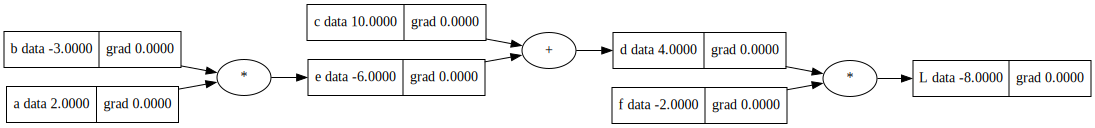

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L' 

draw_dot(L)

The code provided builds upon the previously discussed `Value` class, which acts as a node within a computational graph in the context of automatic differentiation. It demonstrates how to define scalar values `a`, `b`, `c`, and `f` and use them to build a computational graph. The graph computes the expression `L = (a * b + c) * f`, represented in nodes labeled 'e', 'd', and 'L'.

The focus of this explanation is the process of backpropagation and the computation of gradients for every node in the graph, which is crucial for training neural networks. In a neural network setting, the loss function `L` would typically be calculated with respect to the network's weights. Here, these weights are abstractly represented by the scalar variables `a`, `b`, `c`, and `f`.

The fundamental idea behind backpropagation is to compute the derivative of the output value `L` with respect to every node in the graph. These derivatives represent the impact each node has on the final output. They are stored in the `grad` attribute of the `Value` class, which is initialized to zero, signifying that there is initially no effect on the output.

In this context, a gradient of zero means changing the value of a node has no effect on the final output, or loss function. After performing backpropagation, the `grad` attribute will store the actual derivative of `L` with respect to that node. This is essential information when training a neural network because it dictates how to adjust the weights (in this example, `a`, `b`, `c`, and `f`) to minimize the loss function `L`.

The function `draw_dot(L)` is presumably used to visualize this computational graph, including both the `data` and the `grad` of each node. This visualization aids in understanding the forward and backward passes of computation within the graph.

In conclusion, this code snippet creates a simple computational graph using the `Value` class, computes a mathematical expression, and prepares for backpropagation. The next steps would involve the actual calculation of the gradients, enabling the iterative optimization of weights based on their influence on the final output.

## Manual gradient

### base case (`L grad`)

In [ ]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L' 
    
    L2 = L.data + h
    
    print(f'grad: {(L2 - L1) / h}')

lol()

grad: 1.000000000000334


sure enough it's 1

In [ ]:
L.grad = 1

####  f

Here is a generic version of `lol`

In [ ]:
def lol(label):
    def foo(v, label):
        if v.label == label: v.data += h
        
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    
    L1 = L.data
    
    a = Value(2.0, label='a'); foo(a, label)
    b = Value(-3.0, label='b'); foo(b, label)
    c = Value(10.0, label='c'); foo(c, label)
    e = a*b; e.label='e'; foo(e, label)
    d = e + c; d.label='d'; foo(d, label)
    f = Value(-2.0, label='f'); foo(f, label)
    L = d*f; L.label='L'; foo(L, label) 
    
    L2 = L.data
    
    print(f'grad: {(L2 - L1) / h}')

lol('f')

grad: 3.9999999999995595


In [ ]:
f.grad = 4

In [ ]:
lol('d') 

grad: -2.000000000000668


In [ ]:
d.grad = -2

Let's draw what we have up to this point

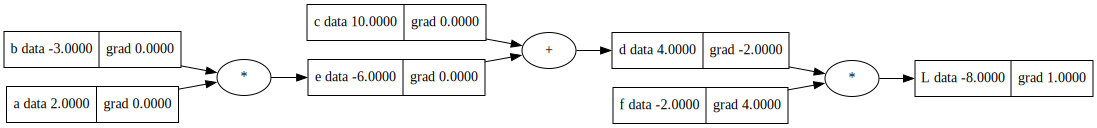

In [ ]:
draw_dot(L)

Sure, here's the step by step derivation for each of the variables:

1. With respect to `a`:

Given that `L = (a*b + c) * f`, we will apply the product rule for differentiation.

The derivative of `a*b` with respect to `a` is `b`, and the derivative of `c` with respect to `a` is `0`. Therefore:

$$
\frac{dL}{da} = f \cdot \frac{d(a*b + c)}{da} = f \cdot (b + 0) = b \cdot f
$$

2. With respect to `b`:

The derivative of `a*b` with respect to `b` is `a`, and the derivative of `c` with respect to `b` is `0`. Therefore:

$$
\frac{dL}{db} = f \cdot \frac{d(a*b + c)}{db} = f \cdot (a + 0) = a \cdot f
$$

3. With respect to `c`:

The derivative of `a*b` with respect to `c` is `0`, and the derivative of `c` with respect to `c` is `1`. Therefore:

$$
\frac{dL}{dc} = f \cdot \frac{d(a*b + c)}{dc} = f \cdot (0 + 1) = f
$$

4. With respect to `f`:

The derivative of `(a*b + c)` with respect to `f` is `0`, and `f` is just `f`, therefore:

$$
\frac{dL}{df} = (a*b + c) \cdot \frac{df}{df} = a*b + c
$$

5. With respect to `e` (where `e = a*b`):

The derivative of `e + c` with respect to `e` is `1`. Therefore:

$$
\frac{dL}{de} = f \cdot \frac{d(e + c)}{de} = f \cdot 1 = f
$$

6. With respect to `d` (where `d = e + c`):

The derivative of `d` with respect to `d` is `1`. Therefore:

$$
\frac{dL}{dd} = f \cdot \frac{df}{df} = f
$$


In [ ]:
lol('e')

grad: -2.000000000000668


In [ ]:
e.grad = -2 # 1 * d.grad

In [ ]:
lol('c')

grad: -1.9999999999988916


In [ ]:
c.grad = -2 # 1 * d.grad

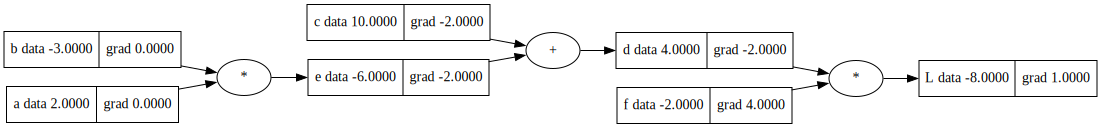

In [ ]:
draw_dot(L)

In [ ]:
lol('a')

grad: 6.000000000000227


In [ ]:
a.grad = 6  # b * e.grad

In [ ]:
lol('b')

grad: -3.9999999999995595


In [ ]:
b.grad = -4 # a * e.grad

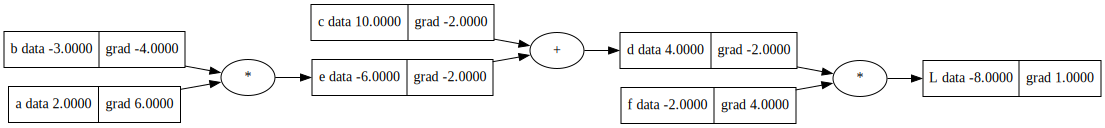

In [ ]:
draw_dot(L)

In [ ]:
#| export
class Value:
    """
    Represents a node within a computational graph.

    This class encapsulates a single value and its relationships in the graph, making it easy to track and manage the value's dependencies, 
    the operation that produced it, and whether it requires a gradient for backpropagation. It's central to the functioning of automatic 
    differentiation within deep learning frameworks.

    Attributes:
        op (Operator)
        _prev (Set['Value']) 
        cached_data (NDArray)
        requires_grad (bool)
    """
    def __init__(self, data, _children=(), _op='', label=''):
        self._data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self._data + other._data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self._data * other._data, (self, other), '*')

        def _backward():
            self.grad += other._data * out.grad
            other.grad += self._data * out.grad
        out._backward = _backward

        return out
    
    def __repr__(self):
        return f"Value(data={self._data}, grad={self.grad})"

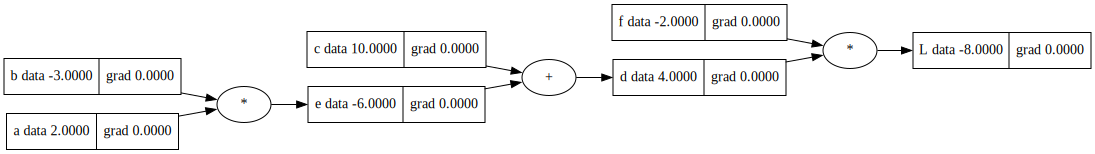

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L' 

draw_dot(L)

In [ ]:
L.grad = 1

In [ ]:
L._backward()

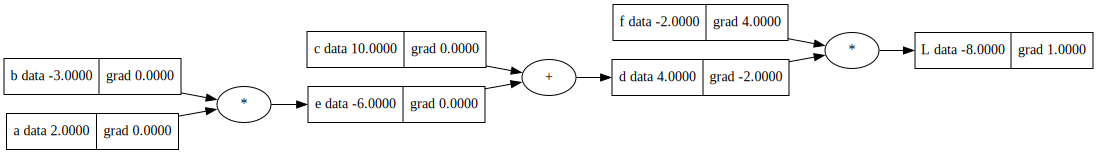

In [ ]:
draw_dot(L)

In [ ]:
d._backward()

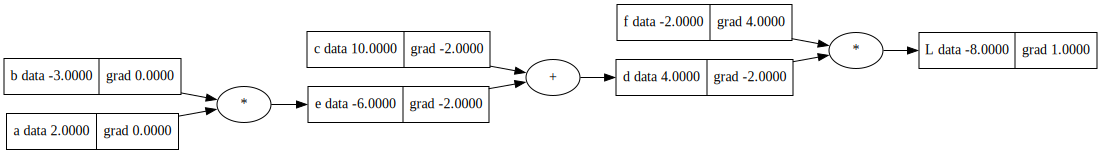

In [ ]:
draw_dot(L)

In [ ]:
c._backward()

We expect that nothing will happen

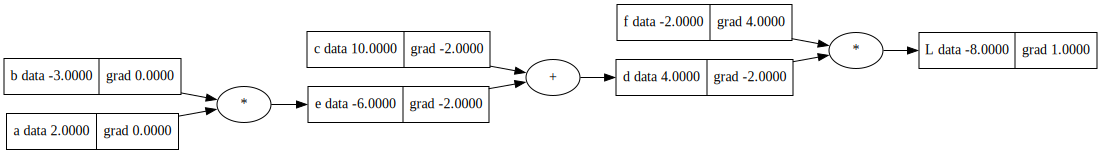

In [ ]:
draw_dot(L)

In [ ]:
e._backward()

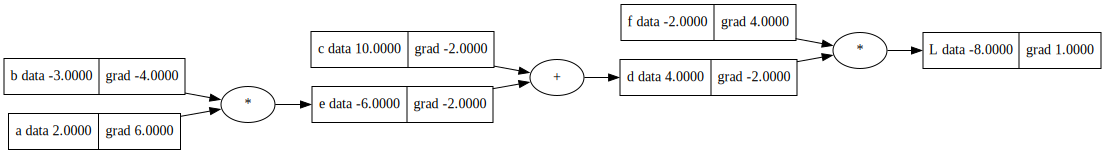

In [ ]:
draw_dot(L)

sure enough, exactly as we did before

We can do thid process automatically using topo sort algorithms, which's will give us the correct order on which to call _backward on

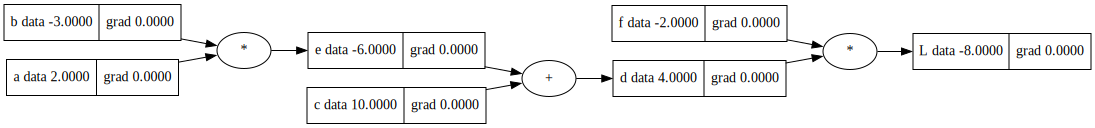

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L' 

draw_dot(L)

In [ ]:
# topological order all of the children in the graph
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(L)

In [ ]:
topo

[Value(data=10.0, grad=0),
 Value(data=-3.0, grad=0),
 Value(data=2.0, grad=0),
 Value(data=-6.0, grad=0),
 Value(data=4.0, grad=0),
 Value(data=-2.0, grad=0),
 Value(data=-8.0, grad=0)]

In [ ]:
# go one variable at a time and apply the chain rule to get its gradient
L.grad = 1
for v in reversed(topo):
    v._backward()

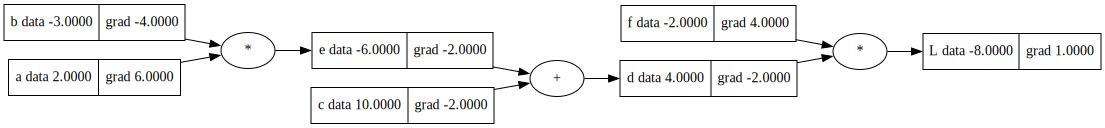

In [ ]:
draw_dot(L)

So let's now update the Value class with this logic

In [ ]:
#| export
class Value:
    """
    Represents a node within a computational graph.

    This class encapsulates a single value and its relationships in the graph, making it easy to track and manage the value's dependencies, 
    the operation that produced it, and whether it requires a gradient for backpropagation. It's central to the functioning of automatic 
    differentiation within deep learning frameworks.

    Attributes:
        op (Operator)
        _prev (Set['Value']) 
        cached_data (NDArray)
        requires_grad (bool)
    """
    def __init__(self, data, _children=(), _op='', label=''):
        self._data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self._data + other._data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self._data * other._data, (self, other), '*')

        def _backward():
            self.grad += other._data * out.grad
            other.grad += self._data * out.grad
        out._backward = _backward

        return out
    
    def __repr__(self):
        return f"Value(data={self._data}, grad={self.grad})"
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

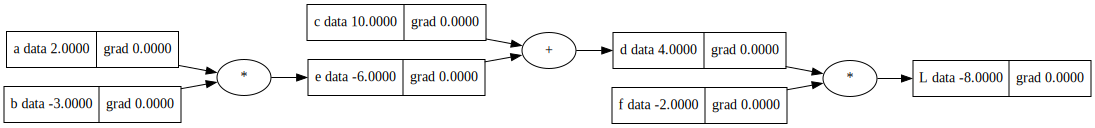

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L' 

draw_dot(L)

In [ ]:
L.backward()

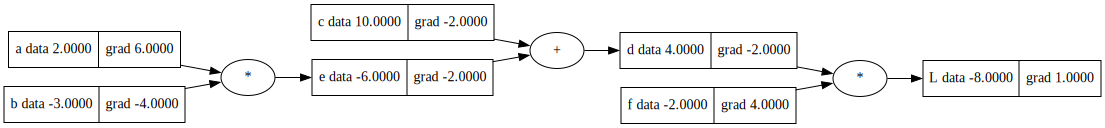

In [ ]:
draw_dot(L)

In [ ]:
#| export
class Value:
    """
    A class representing a scalar value and its gradient in a computational graph.
    
    Attributes:
    - data (float): the scalar value associated with this node
    - grad (float): the gradient of the output of the computational graph w.r.t. this node's value
    - label (str): a label for this node, used for debugging and visualization purposes
    - _op (str): a string representation of the operation that produced this node in the computational graph
    - _prev (set of Value objects): the set of nodes that contributed to the computation of this node
    - _backward (function): a function that computes the gradients of this node w.r.t. its inputs
    
    Methods:
    - __init__(self, data, children=(), op='', label=''): Initializes a Value object with the given data, children, op, and label
    - __repr__(self): Returns a string representation of this Value object
    - __add__(self, other): Implements the addition operation between two Value objects
    - __mul__(self, other): Implements the multiplication operation between two Value objects
    - item(self): Returns the scalar value associated with this Value object
    - tanh(self): Applies the hyperbolic tangent function to this Value object and returns a new Value object
    """
    
    def __init__(
        self,
        data,
        children=(),
        op='',
        label=''
        ):
        """
        Initializes a Value object with the given data, children, op, and label.
        
        Args:
        - data (float): the scalar value associated with this node
        - children (tuple of Value objects): the nodes that contributed to the computation of this node
        - op (str): a string representation of the operation that produced this node in the computational graph
        - label (str): a label for this node, used for debugging and visualization purposes
        """
        
        self._data = data
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        
    def __repr__(self):
        """
        Returns a string representation of this Value object.
        
        Returns:
        - str: a string representation of this Value object
        """
        return f"Value({self._data})"
    
    def __add__(self, other):
        """
        Implements the addition operation between two Value objects.
        
        Args:
        - other (Value): the other Value object to add to this one
        
        Returns:
        - Value: a new Value object representing the sum of this Value object and the other one
        """
        
        other = Value(other) if not isinstance(other, Value) else other
        
        out  = Value(self._data + other._data, children=(self, other), op='+')
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        """
        Implements the addition operation between two Value objects.
        
        Args:
        - other (Value): the other Value object to add to this one
        
        Returns:
        - Value: a new Value object representing the sum of this Value object and the other one
        """
        return self.__add__(other)
    
    def __sub__(self, other):
        """
        Implements the subtraction operation between two Value objects.
        
        Args:
        - other (Value): the other Value object to subtract from this one
        
        Returns:
        - Value: a new Value object representing the difference between this Value object and the other one
        """
        return self + (-other)
    
    def __rsub__(self, other):
        """
        Implements the subtraction operation between two Value objects.
        
        Args:
        - other (Value): the other Value object to subtract from this one
        
        Returns:
        - Value: a new Value object representing the difference between this Value object and the other one
        """
        return self.__neg__().__add__(other)
    
    def __mul__(self, other):
        """
        Implements the multiplication operation between two Value objects.
        
        Args:
        - other (Value): the other Value object to multiply with this one
        
        Returns:
        - Value: a new Value object representing the product of this Value object and the other one
        """
        
        other = Value(other) if not isinstance(other, Value) else other
        out =  Value(self._data * other._data, children=(self, other), op='*')
        
        def _backward():
            self.grad += other._data * out.grad
            other.grad += self._data * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        """
        Implements the multiplication operation between two Value objects.
        
        Args:
        - other (Value): the other Value object to multiply with this one
        
        Returns:
        - Value: a new Value object representing the product of this Value object and the other one
        """
        return self.__mul__(other)
    
    def __neg__(self):
        """
        Implements the negation operation on this Value object.
        
        Returns:
        - Value: a new Value object representing the negation of this Value object
        """
        return self * -1
    
    
    def __pow__(self, other):
        """
        Implements the power operation between this Value object and another Value object or a scalar.
        
        Args:
        - other (Value or float): the other Value object or scalar to raise this Value object to
        
        Returns:
        - Value: a new Value object representing the power of this Value object and the other one
        """
        assert isinstance(other, (float, int)), "other must be a scalar"
        
        out = Value(self._data ** other, children=(self, ), op='**')
        
        def _backward(): self.grad += other * self._data ** (other - 1) * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def exp(self):
        """
        Compute the exponential of a Value object's data attribute.

        Returns:
        - out: A new Value object that represents the exponential of the original Value object.
            This object stores a reference to the original Value object as a child node.

        Comments:
        - The exponential function is computed using the math.exp() function.
        - The backward pass is defined as a closure function _backward(), which computes the gradient of the original
        Value object using the product rule of differentiation and adds it to the gradient of the output object.
        - The _backward() function is assigned as an attribute to the output object for later use during backpropagation.
        """
        
        x = math.exp(self._data)
        out = Value(x, children=(self,), op='exp')
        
        def _backward(): self.grad += x * out.grad # x = exp(self._data) so x' = x (derivative of exp(x) is exp(x))
        out._backward = _backward
        
        return out
    
    def tanh(self):
        """
        Applies the hyperbolic tangent function to the data of this `Value` object and returns a new `Value` object 
        with the resulting data. This operation is an element-wise operation.
        """
        out = Value(torch.tanh(torch.tensor(self._data)), children=(self,), op='tanh')
        def _backward(): self.grad += (1 - out.data ** 2) * out.grad
        out._backward = _backward
        
        return out
    
    def relu(self):
        """
        Applies the rectified linear unit function to the data of this `Value` object and returns a new `Value` object 
        with the resulting data. This operation is an element-wise operation.
        """
        out = Value(max(0, self._data), children=(self,), op='relu')
        
        def _backward(): self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        
        return out
    
    @property
    def data(self):
        """
        Returns a tensor that shares the data with the current tensor but is detached from the computational graph.

        Example:
        >>> t = Tensor([1, 2, 3], requires_grad=True)
        >>> print(t.data)
        Tensor([1, 2, 3])
        """
        return self._data

    @data.setter
    def data(self, value):
        self._data = value

    
    def item(self):
        """
        Return the scalar value being stored in the current Value as a Python float.
        
        Args:
            None
        
        Returns:
            float: The scalar value being stored in the current Value as a Python float.
        
        """
        return self._data
    
    def is_leaf(self):
        return self.op is None

    def __del__(self):
        global TENSOR_COUNTER
        TENSOR_COUNTER -= 1
    
    
    def backward(self) -> None:
        """
        Performs backpropagation by computing the gradients of all variables with respect to the loss.

        This method sets the gradient of the computational graph's output variable to 1.0 and then computes
        the gradients of all variables in the graph by performing a reverse topological sort and calling the
        `_backward` method on each variable in the resulting order.

        Returns:
            None
        """
        # Set the gradient of the output variable to 1.0 to start the backpropagation process.
        self.grad = 1.0

        # Perform a reverse topological sort to determine the order in which to compute gradients.
        for v in self._topological_sort():
            # Call the `_backward` method on each variable in the resulting order to compute its gradient.
            v._backward()

        
    def _topological_sort(self):
        """
        Given a node in a computational graph, returns a list of all nodes in the graph sorted in topological order.

        Args:
            node: A node in a computational graph (i.e self).

        Returns:
            A list of all nodes in the graph sorted in topological order.
        """
        
        
        visited = set()
        topo = []

        def build_topo(node):
            visited.add(node)
            for child in node._prev:
                if child not in visited:
                    build_topo(child)
            topo.append(node)

        build_topo(self)
        topo.reverse()
        return topo    
        


In [ ]:
#| export
NDArray = numpy.ndarray
LAZY_MODE = False
TENSOR_COUNTER = 0

In [ ]:
#| export
class Device:
    """Indicates the device supporting an NDArray."""


class CPUDevice(Device):
    """Represents data that sits in CPU"""

    def __repr__(self):
        return "minima.cpu()"

    def __hash__(self):
        return self.__repr__().__hash__()

    def __eq__(self, other):
        return isinstance(other, CPUDevice)

    def enabled(self):
        return True

def cpu():
    """Return cpu device"""
    return CPUDevice()

def all_devices():
    """return a list of all available devices"""
    return [cpu()]

In [ ]:
#| export
class Operator:
    
    def __call__(self, *args):
        raise NotImplementedError()
        
    def compute(self, *args: Tuple[NDArray]):
        raise NotImplementedError()
        
    def gradient(self, out_grad: 'Value', node: 'Value') -> Union['Value', Tuple['Value']]:
        raise NotImplementedError()

In [ ]:
#| export
class TensorOp(Operator):
    """ Op class specialized to output tensors, will be alternate subclasses for other structures """

    def __call__(self, *args):
        return Tensor.make_from_op(self, args)


``` python
#| export
class Value:
    """
    Represents a node within a computational graph.

    This class encapsulates a single value and its relationships in the graph, making it easy to track and manage the value's dependencies, 
    the operation that produced it, and whether it requires a gradient for backpropagation. It's central to the functioning of automatic 
    differentiation within deep learning frameworks.

    Attributes:
        op (Operator)
        _prev (Set['Value']) 
        cached_data (NDArray)
        requires_grad (bool)
    """
    def __init__(self,
                 op: Operator, # The operator that produced this node. If the node was initialized from actual data, this is 'None'.
                 prev: Set['Value'], # The set of values that this value directly depends on. It's the union of the `_next` sets of all the values in `args`.
                 cached_data: NDArray, # The actual data for this value. It's `None` for values that aren't yet computed.
                 requires_grad: bool): # Specifies whether this node requires a gradient. This is `False` for nodes that don't need gradients.
        
        self._op = op
        self._prev = op
        self.cached_data = cached_data
        self.requires_grad = requires_grad
```

In [ ]:
#| export
class Tensor(Value):
    """
    A Tensor represents a multidimensional array of values in a computational graph.

    Attributes:
    - data: The actual data of the tensor. It is computed lazily.
    - children: Other tensors that this tensor depends on for computing its value.
    - requires_grad: Whether this tensor needs to compute gradients.

    Methods:
    - realize_data: Computes and returns the actual data for this tensor.
    - shape: Returns the shape of this tensor.
    - dtype: Returns the data type of this tensor.

    Example:
    >>> t1 = Tensor([[1.0, 2.0], [3.0, 4.0]])
    >>> print(t1.shape)
    (2, 2)
    >>> print(t1.dtype)
    float64
    """

    def __init__(
        self,
        array,
        *,
        device: Optional[Device] = None,
        dtype=None,
        requires_grad=True,
        **kwargs
    ):
        
        """
        Initializes the tensor with given array, device, and data type.

        Args:
        - array: A numeric array-like object (e.g., list, numpy array, or another tensor).
        - device: The device where the tensor should be allocated.
        - dtype: The desired data type for the tensor.
        - requires_grad: Whether the tensor requires gradient computation.

        Returns:
        None.
        """
        
        if isinstance(array, Tensor):
            if device is None:
                device = array.device
            if dtype is None:
                dtype = array.dtype
            if device == array.device and dtype == array.dtype:
                data = array.realize_data()
            else:
                # fall back, copy through numpy conversion
                data = Tensor._array_from_numpy(
                    array.numpy(), device=device, dtype=dtype
                )
        else:
            device = device if device else cpu()
            data = Tensor._array_from_numpy(array, device=device, dtype=dtype)

        self._init(None, (), data=data, requires_grad=requires_grad, )
        
    def __repr__(self):
        return "minima.Tensor(" + str(self.realize_data()) + ")"

    def __str__(self):
        return self.realize_data().__str__()
        
    def _init(
        self,
        op: Optional[Operator],
        children: Set["Tensor"],
        *,
        num_outputs: int = 1,
        data: List[object] = None,
        requires_grad: Optional[bool] = None
    ):
        """
        Internal initialization function for the Tensor.

        Args:
        - op: The operator that produces this tensor.
        - children: Set of tensors that this tensor depends on.
        - num_outputs: Number of outputs that the operator produces.
        - data: Actual data of the tensor, computed lazily.
        - requires_grad: Whether this tensor requires gradient computation.

        Returns:
        None.
        """
        
        global TENSOR_COUNTER
        TENSOR_COUNTER += 1
        if requires_grad is None:
            requires_grad = any(child.requires_grad for child in children)
        self._op = op
        self._data = data
        self.children = children
        self.num_outputs = num_outputs
        self.requires_grad = requires_grad
        
    def realize_data(self):
        """
        If the data of this tensor has not been computed, computes and caches it.
        Otherwise, returns the cached data.

        Returns:
        The actual data of this tensor.
        """
        
        if self._data is None:
            self._data = self._op.compute(*[child.realize_data() for child in self.children])
        return self._data
    
    @staticmethod
    def _array_from_numpy(numpy_array, device, dtype):
        """
        Converts a numpy array into an array suitable for the given device and data type.

        Args:
        - numpy_array: The numpy array to convert.
        - device: The device where the converted array should be allocated.
        - dtype: The desired data type for the converted array.

        Returns:
        The converted array.
        """

        if ARRAY_API is numpy:
            return numpy.array(numpy_array, dtype=dtype)
        return ARRAY_API.array(numpy_array, device=device, dtype=dtype)
    
    @staticmethod
    def make_from_op(op: Operator, children: Tuple["Value"]):
        """
        Creates a new tensor from a given operator and its children.

        Args:
        - op: The operator that produces the tensor.
        - children: The tensors that the operator depends on.

        Returns:
        The newly created tensor.
        """
        
        tensor = Tensor.__new__(Tensor)
        tensor._init(op, children)
        if not LAZY_MODE:
            tensor.realize_data()
        return tensor
    
    def create_detached_tensor(self, data, requires_grad=False) -> 'Tensor':
        """
        Creates a new tensor that shares the data with the current tensor but detaches it from the computational graph.

        Args:
        - data: The data for the new tensor. It can be any array-like object or a Tensor. 
                 If a Tensor is provided, its underlying data is extracted.
        - requires_grad (optional): Whether the new tensor requires gradient computation. 
                                    The default value is False, meaning that the new tensor will be detached from the computational graph.

        Returns:
        A new Tensor that shares the data with the current tensor but is detached from the computational graph.

        Example:
        >>> t = Tensor([1, 2, 3], requires_grad=True)
        >>> t_detached = t.create_detached_tensor(t.data)
        >>> print(t_detached)
        Tensor([1, 2, 3])
        """
        tensor = Tensor.__new__(Tensor)
        return tensor._init(None,
                            set(),
                            data=data if not isinstance(data, Tensor) else data.realize_data(),
                            requires_grad=requires_grad
                           )
        
        
    def detach(self) -> 'Tensor':
        """
        Creates a new tensor that shares the data with the current tensor but is detached from the computational graph.

        Returns:
        A new Tensor that shares the data with the current tensor but is detached from the computational graph.

        Example:
        >>> t = Tensor([1, 2, 3], requires_grad=True)
        >>> t_detached = t.detach()
        >>> print(t_detached)
        Tensor([1, 2, 3])
        """
        return self.create_detached_tensor(self.realize_data())
    
    def numpy(self):
        """
        Converts the tensor data into a NumPy array.

        Returns:
        The data of the tensor as a NumPy array.

        Example:
        >>> t = Tensor([1, 2, 3])
        >>> np_array = t.numpy()
        >>> print(type(np_array))
        <class 'numpy.ndarray'>
        """
        
        data = self.realize_data()
        if ARRAY_API is numpy: return data
        return data.numpy()  # Data is of type NDArray!

    @property
    def data(self):
        """
        Returns a tensor that shares the data with the current tensor but is detached from the computational graph.

        Example:
        >>> t = Tensor([1, 2, 3], requires_grad=True)
        >>> print(t.data)
        Tensor([1, 2, 3])
        """
        return self.detach()

    @data.setter
    def data(self, value):
        """
        Sets the data of the current tensor to the data of another tensor. The tensors must be of the same dtype.

        Args:
        - value: A tensor whose data is used to set the data of the current tensor.

        Raises:
        - AssertionError: If value is not a tensor or if the dtype of value is not the same as the dtype of the current tensor.

        Example:
        >>> t = Tensor([1, 2, 3], dtype=float)
        >>> t2 = Tensor([4, 5, 6], dtype=float)
        >>> t.data = t2
        >>> print(t.data)
        Tensor([4, 5, 6])
        """
        print(type(value), type(Tensor))
        assert isinstance(value, Tensor)
        assert value.dtype == self.dtype, "The dtype of the given tensor (%s) is not the same as the dtype of the current tensor (%s)." % (
            value.dtype,
            self.dtype,
        )
        self._data = value.realize_data()

    
    @property
    def shape(self):
        """
        Returns the shape of this tensor.

        Returns:
        A tuple representing the shape of this tensor.
        """
        return self.realize_data().shape

    @property
    def dtype(self):
        """
        Returns the data type of this tensor.

        Returns:
        The data type of this tensor.
        """
        return self.realize_data().dtype
    
    @property
    def device(self):
        """
        Returns the device on which the tensor data is stored.

        Returns:
        The device on which the tensor data is stored. If the data is stored in a NumPy array, returns a CPU device.

        Example:
        >>> t = Tensor([1, 2, 3])
        >>> device = t.device
        >>> print(device)
        cpu
        """
        
        data = self.realize_data()
        if ARRAY_API is numpy: return cpu()
        return data.device
    
    def backward(self, out_grad: Optional['Tensor']=None) -> None:
        out_grad = out_grad if not out_grad else Tensor(ARRAY_API.ones(self.shape))
        self._backward(self, out_grad)
    
    def __add__(self, other: Union['Tensor', int, float]) -> 'Tensor':
        """
        Implements the addition operation between two Tensors or a Tensor and a scalar.

        Args:
        - other (Tensor or scalar): the other Tensor or scalar to add to this one

        Returns:
        - Tensor: a new Tensor object representing the sum of this Tensor and the other one
        """
        if isinstance(other, Tensor):
            # Ensure both tensors have the same shape for addition
            if self.shape != other.shape:
                raise AssertionError(f"Tensors must be of the same shape for addition. Got {self.shape} and {other.shape}.")

            return mi.operators.EWiseAdd()(self, other)

        elif isinstance(other, (int, float)):
            return mi.operators.AddScalar(scalar=other)(self)

        else:
            raise ValueError(f"Unsupported operand type for +: '{type(self).__name__}' and '{type(other).__name__}'")
    
    def __sub__(self, other: Union['Tensor', int, float]) -> 'Tensor':
        """
        Implements the subtraction operation between two Tensors or a Tensor and a scalar.

        Args:
        - other (Tensor or scalar): the other Tensor or scalar to subtract from this one

        Returns:
        - Tensor: a new Tensor object representing the difference between this Tensor and the other one

        Raises:
        - AssertionError: If the two Tensors don't have the same shape
        - ValueError: If the other operand is neither a Tensor nor a scalar
        """
        if isinstance(other, Tensor):
            # Ensure both tensors have the same shape for subtraction
            if self.shape != other.shape:
                raise AssertionError(f"Tensors must be of the same shape for subtraction. Got {self.shape} and {other.shape}.")

            return mi.operators.EWiseAdd()(negate(self), other)

        elif isinstance(other, (int, float)):
            return mi.operators.AddScalar(scalar=-other)(self)

        else:
            raise ValueError(f"Unsupported operand type for -: '{type(self).__name__}' and '{type(other).__name__}'")


            
    def __mul__(self, other: Union['Tensor', int, float]) -> 'Tensor':
        """
        Implements the multiplication operation between two Tensors or a Tensor and a scalar.

        Args:
        - other (Tensor or scalar): the other Tensor or scalar to multiply with this one

        Returns:
        - Tensor: a new Tensor object representing the product of this Tensor and the other one
        """
        if isinstance(other, Tensor):
            # Ensure both tensors have the same shape for multiplication
            if self.shape != other.shape:
                raise AssertionError(f"Tensors must be of the same shape for multiplication. Got {self.shape} and {other.shape}.")

            return mi.operators.EWiseMul()(self, other)

        elif isinstance(other, (int, float)):
            return mi.operators.MulScalar(scalar=other)(self)

        else:
            raise ValueError(f"Unsupported operand type for *: '{type(self).__name__}' and '{type(other).__name__}'")
            
    def __pow__(self, other):
        
        if isinstance(other, Tensor):
            raise NotImplementedError()        
        if isinstance(other, (int, float)):
            return mi.operators.PowerScalar(scalar=other)(self)
        else:
            raise ValueError(f"Unsupported operand type for ^: '{type(self).__name__}' and '{type(other).__name__}'")

    def __truediv__(self, other: Union['Tensor', int, float]) -> 'Tensor':
        """
        Implements the division operation between two Tensors or a Tensor and a scalar.

        Args:
        - other (Tensor or scalar): the other Tensor or scalar to divide to this one

        Returns:
        - Tensor: a new Tensor object representing the result of division of this Tensor and the other one
        """
        if isinstance(other, Tensor):
            # Ensure both tensors have the same shape for addition
            if self.shape != other.shape:
                raise AssertionError(f"Tensors must be of the same shape for addition. Got {self.shape} and {other.shape}.")

            return mi.operators.EWiseDiv()(self, other)

        elif isinstance(other, (int, float)):
            return mi.operators.DivScalar(scalar=other)(self)

        else:
            raise ValueError(f"Unsupported operand type for /: '{type(self).__name__}' and '{type(other).__name__}'")

    
    def __rtruediv__(self, other): # other / self
        """
        Implements the right division operation between a scalar or a Tensor and this Tensor.

        Args:
        - other (Tensor or scalar): the other Tensor or scalar to divide by this one

        Returns:
        - Tensor: a new Tensor object representing the result of the division

        Example:
        - If the method is called as `other.__rtruediv__(self)`, this corresponds to `other / self` in usual operations.
        """
        return self.__pow__(-1).__mul__(other)
        # other * self**-1

    def __matmul__(self, other):
        """
        Implements the matrix multiplication operation between this Tensor and another Tensor.

        Args:
        - other (Tensor): the other Tensor to multiply with this one

        Returns:
        - Tensor: a new Tensor object representing the result of the matrix multiplication

        Example:
        - If the method is called as `self.__matmul__(other)`, this corresponds to `self @ other` in usual operations.
        """
        return mi.ops.MatMul()(self, other)

    def _backward(self, out_grad: 'Tensor') -> None:
        pass


In [ ]:
#| hide
def test_sanity_check():

    x = mi.Tensor(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    assert xmg.grad == xpt.grad.item()

def test_more_ops():

    a = mi.Tensor([-4.0])
    b = mi.Tensor([2.0])
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol

In [ ]:
import numpy as np
import unittest
from minima.autograd import Tensor

class TestTensor(unittest.TestCase):
    
    def test_create_tensor(self):
        t1 = Tensor([1, 2, 3])
        self.assertTrue(np.array_equal(t1.realize_data(), np.array([1, 2, 3])))
        self.assertEqual(t1.shape, (3,))
        self.assertEqual(t1.dtype, np.float64)
        
        t2 = Tensor([[1, 2], [3, 4]])
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([[1, 2], [3, 4]])))
        self.assertEqual(t2.shape, (2, 2))
        self.assertEqual(t2.dtype, np.float64)
        
        t3 = Tensor(np.array([1, 2, 3]), dtype=np.int32)
        self.assertTrue(np.array_equal(t3.realize_data(), np.array([1, 2, 3], dtype=np.int32)))
        self.assertEqual(t3.shape, (3,))
        self.assertEqual(t3.dtype, np.int32)
        
    def test_create_tensor_from_tensor(self):
        t1 = Tensor([1, 2, 3])
        t2 = Tensor(t1)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3])))
        self.assertEqual(t2.shape, (3,))
        self.assertEqual(t2.dtype, np.float64)
        
        t3 = Tensor(np.array([1, 2, 3]), dtype=np.int32)
        t4 = Tensor(t3)
        self.assertTrue(np.array_equal(t4.realize_data(), np.array([1, 2, 3], dtype=np.int32)))
        self.assertEqual(t4.shape, (3,))
        self.assertEqual(t4.dtype, np.int32)
        
    def test_create_tensor_with_device(self):
        t1 = Tensor([1, 2, 3], device='cpu')
        self.assertEqual(t1.device, 'cpu')
        
        t2 = Tensor([1, 2, 3], device='cuda')
        self.assertEqual(t2.device, 'cuda')
        
    def test_create_tensor_with_requires_grad(self):
        t1 = Tensor([1, 2, 3], requires_grad=True)
        self.assertTrue(t1.requires_grad)
        
        t2 = Tensor([1, 2, 3], requires_grad=False)
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_with_kwargs(self):
        t1 = Tensor([1, 2, 3], device='cuda', dtype=np.float32, requires_grad=True)
        self.assertEqual(t1.device, 'cuda')
        self.assertEqual(t1.dtype, np.float32)
        self.assertTrue(t1.requires_grad)
        
    def test_create_tensor_from_numpy(self):
        np_array = np.array([1, 2, 3])
        t1 = Tensor(np_array)
        self.assertTrue(np.array_equal(t1.realize_data(), np_array))
        self.assertEqual(t1.shape, (3,))
        self.assertEqual(t1.dtype, np.float64)
        
        np_array = np.array([1, 2, 3], dtype=np.int32)
        t2 = Tensor(np_array)
        self.assertTrue(np.array_equal(t2.realize_data(), np_array))
        self.assertEqual(t2.shape, (3,))
        self.assertEqual(t2.dtype, np.int32)
        
    def test_create_tensor_from_numpy_with_device(self):
        np_array = np.array([1, 2, 3])
        t1 = Tensor(np_array, device='cuda')
        self.assertEqual(t1.device, 'cuda')
        
        np_array = np.array([1, 2, 3], dtype=np.int32)
        t2 = Tensor(np_array, device='cuda')
        self.assertEqual(t2.device, 'cuda')
        
    def test_create_tensor_from_numpy_with_requires_grad(self):
        np_array = np.array([1, 2, 3])
        t1 = Tensor(np_array, requires_grad=True)
        self.assertTrue(t1.requires_grad)
        
        np_array = np.array([1, 2, 3], dtype=np.int32)
        t2 = Tensor(np_array, requires_grad=False)
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_numpy_with_kwargs(self):
        np_array = np.array([1, 2, 3])
        t1 = Tensor(np_array, device='cuda', dtype=np.float32, requires_grad=True)
        self.assertEqual(t1.device, 'cuda')
        self.assertEqual(t1.dtype, np.float32)
        self.assertTrue(t1.requires_grad)
        
    def test_create_tensor_from_tensor_with_device(self):
        t1 = Tensor([1, 2, 3], device='cpu')
        t2 = Tensor(t1, device='cuda')
        self.assertEqual(t2.device, 'cuda')
        
    def test_create_tensor_from_tensor_with_requires_grad(self):
        t1 = Tensor([1, 2, 3], requires_grad=True)
        t2 = Tensor(t1, requires_grad=False)
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_kwargs(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32)
        t2 = Tensor(t1, device='cuda', dtype=np.float64)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32)
        t2 = Tensor(t1, device='cpu', dtype=np.float32)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=True)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=False)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_true_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=False)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_false_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=True)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_true_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_false_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=True)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=True)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=False)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_true_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=False)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_false_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=True)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=True)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_true_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_false_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=True)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertTrue(t2.requires_grad)

In [ ]:
import nbdev; nbdev.nbdev_export()